In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import feature.random_graph_dataset as random_graph_dataset
import feature.graph_conversions as graph_conversions
import model.discrete_diffusers as discrete_diffusers
import torch
import torch_geometric
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
out_path = "/gstore/home/tsenga5/discrete_graph_diffusion/figures/discrete_diffusion_summary"

os.makedirs(out_path, exist_ok=True)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [4]:
# Create the data loader for training
node_dim = 1

dataset = random_graph_dataset.RandomGraphDataset(
    node_dim, num_items=100,
    graph_type="community", num_nodes=8, num_comms=1
)
data_loader = torch_geometric.loader.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=0  # TODO: allow multi-processing
)

/gstore/home/tsenga5/miniconda3/envs/graph-diff/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  data[key] = torch.tensor(value)


bit-flip


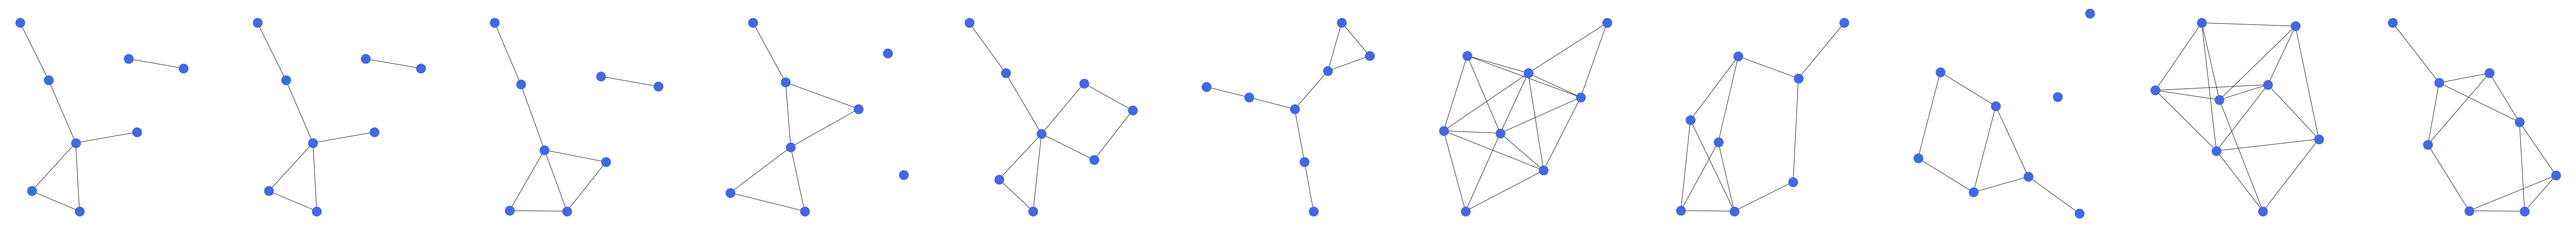

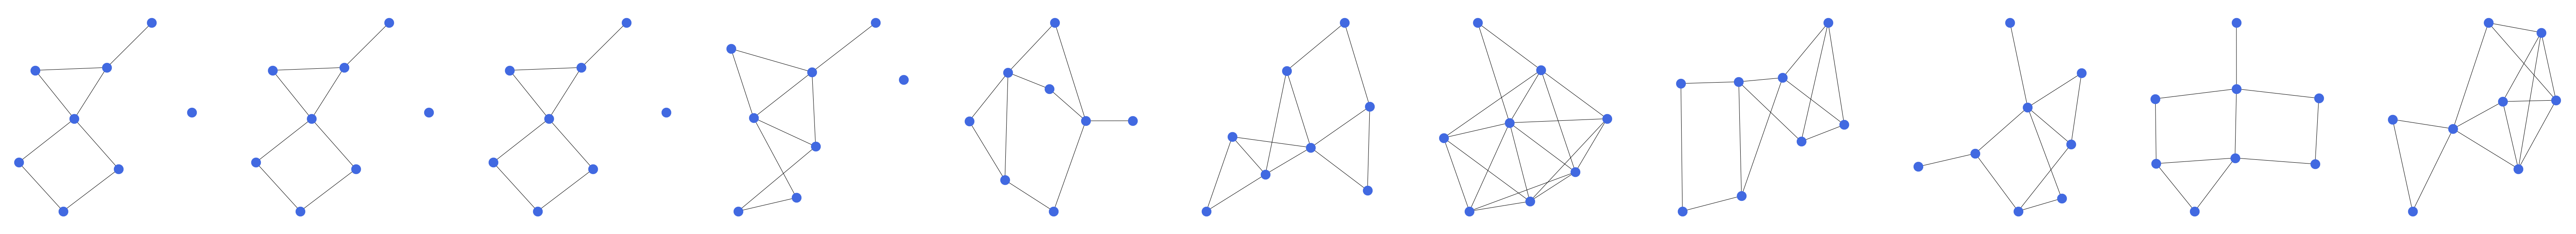

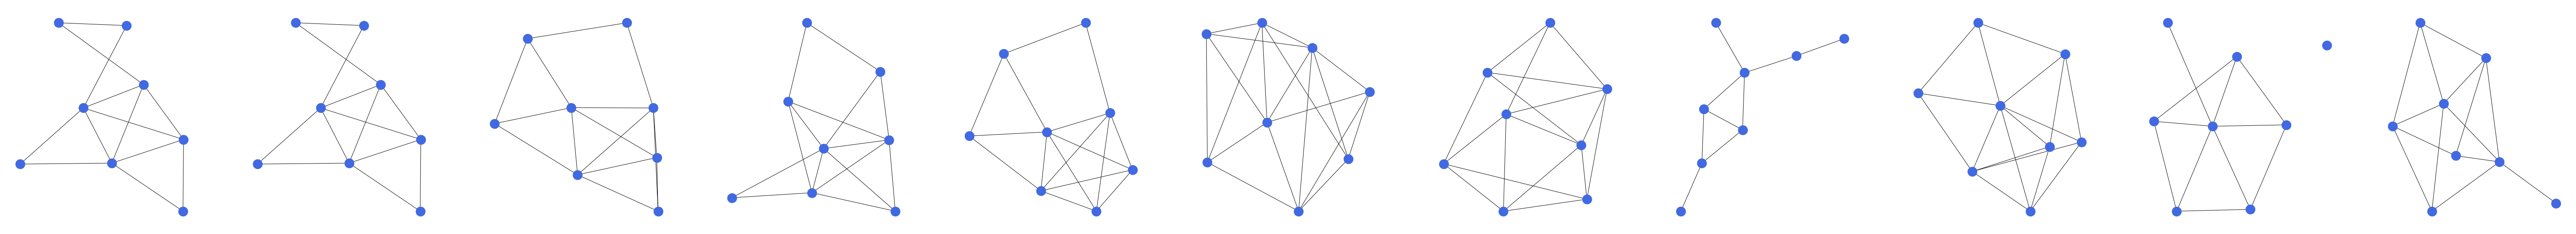

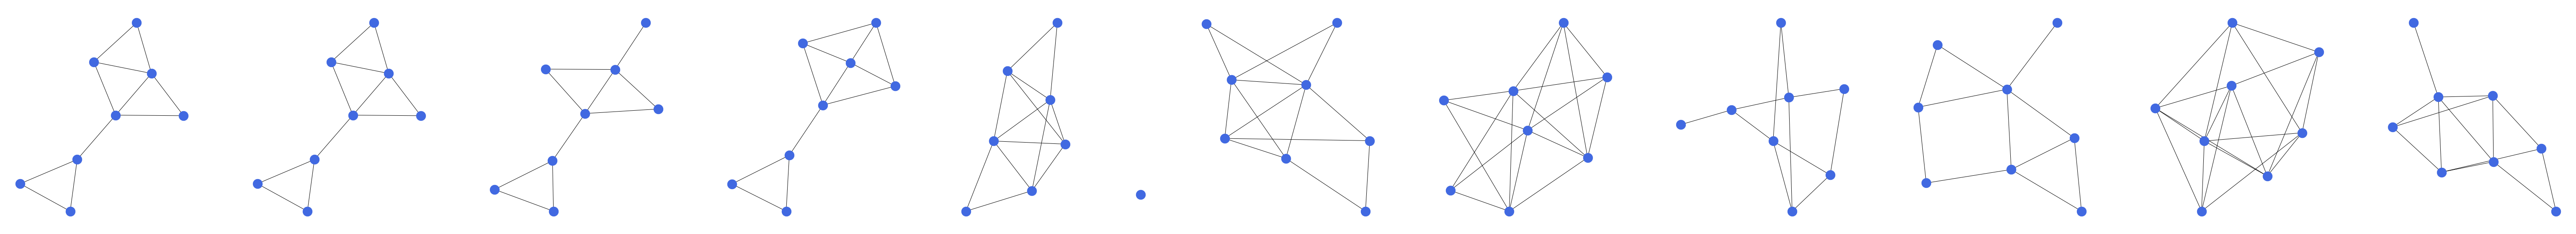

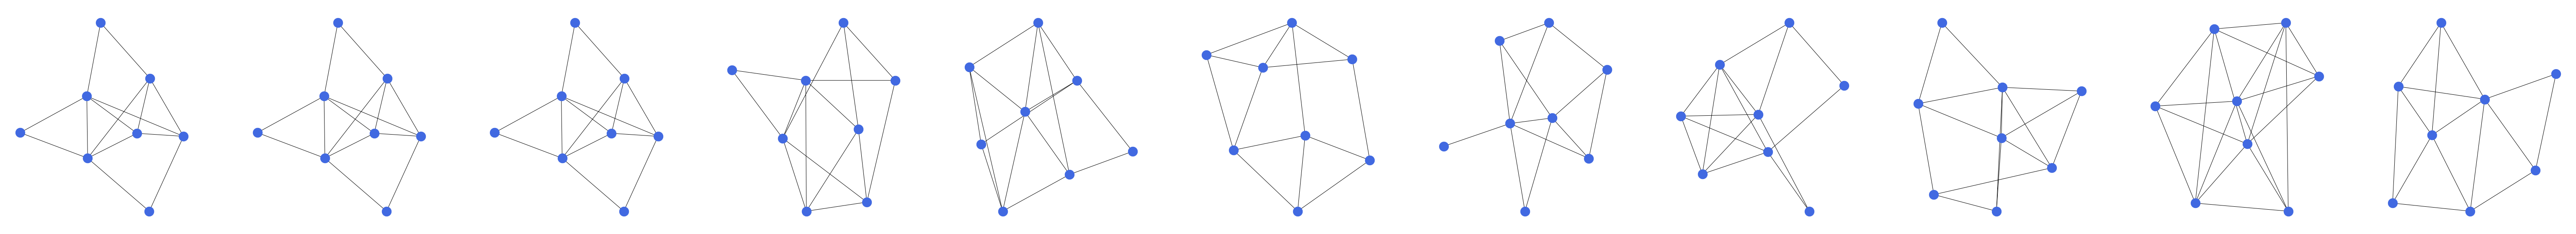

bit-one


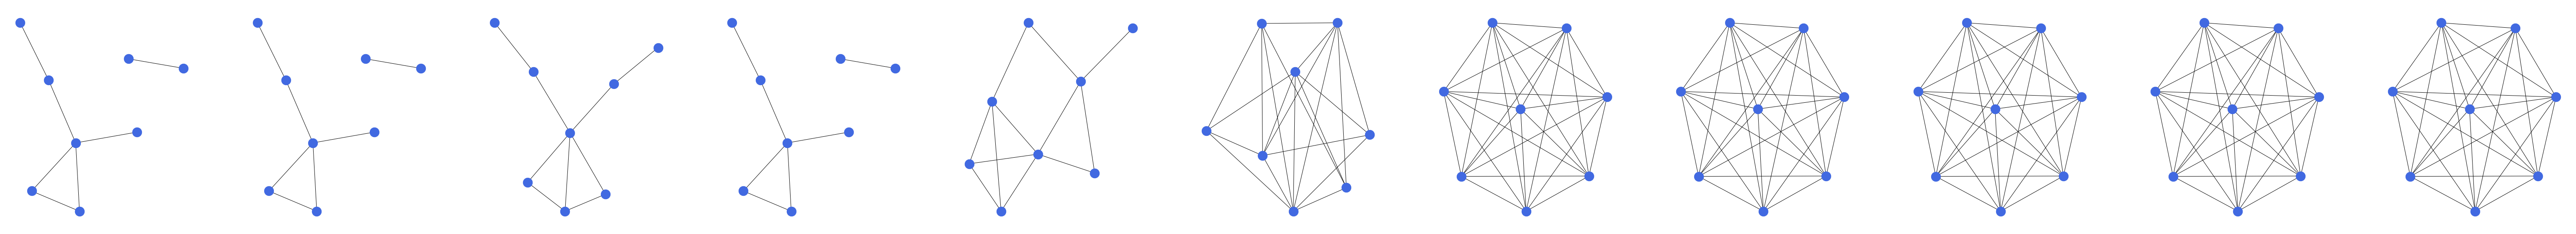

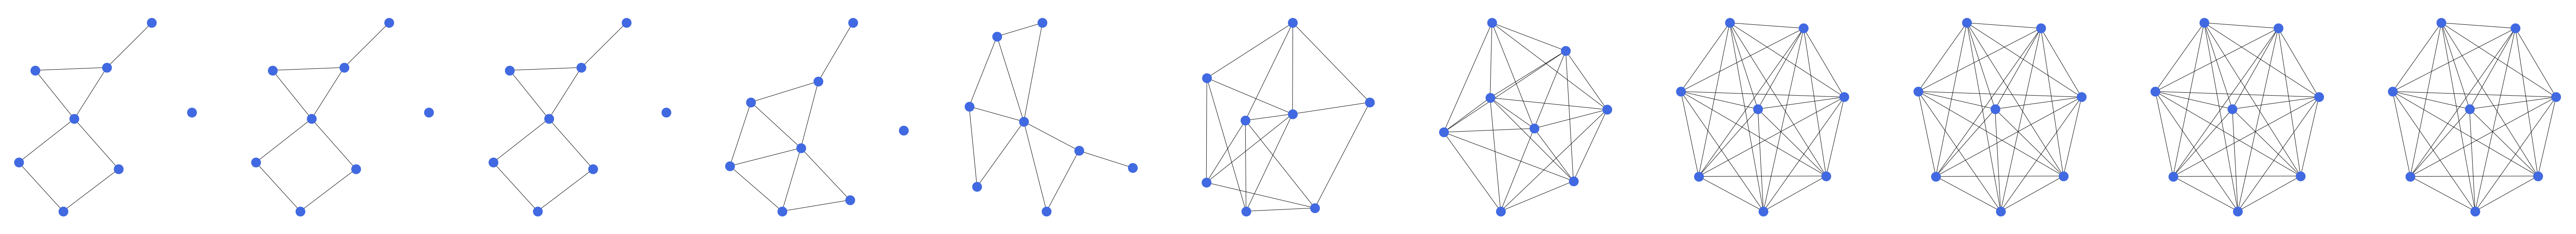

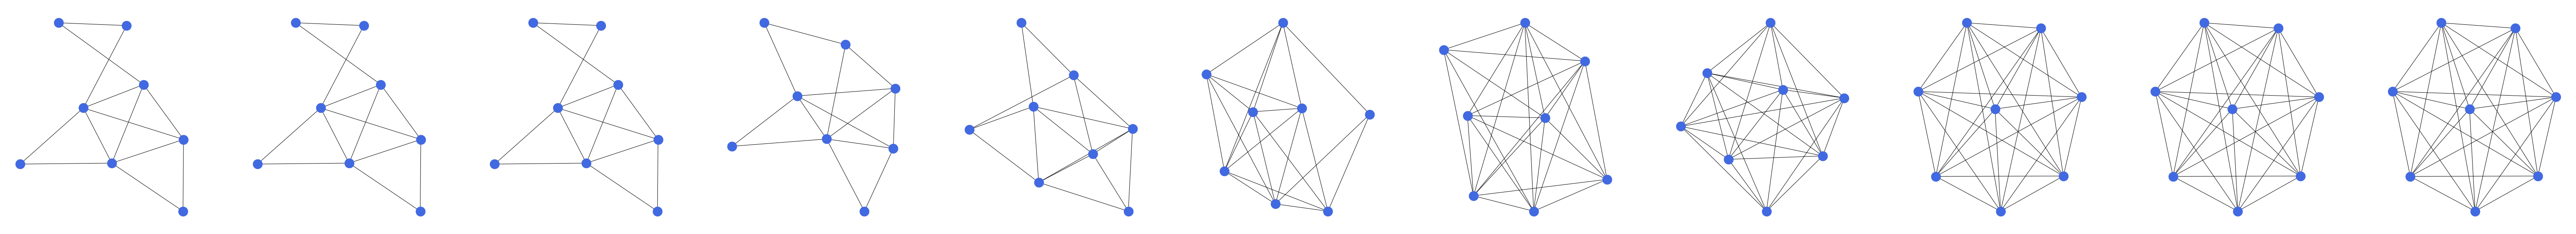

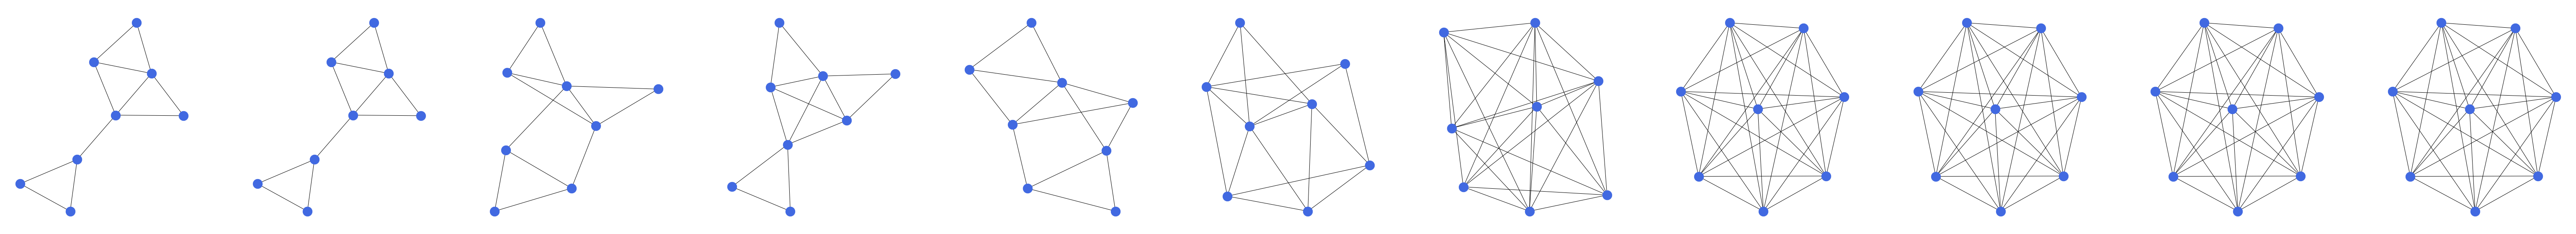

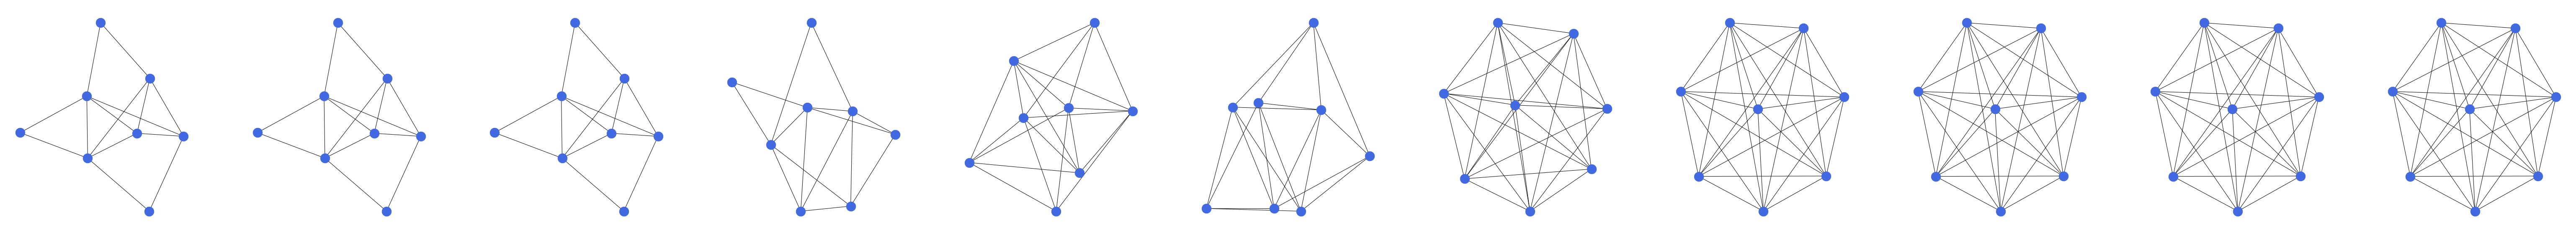

bit-zero


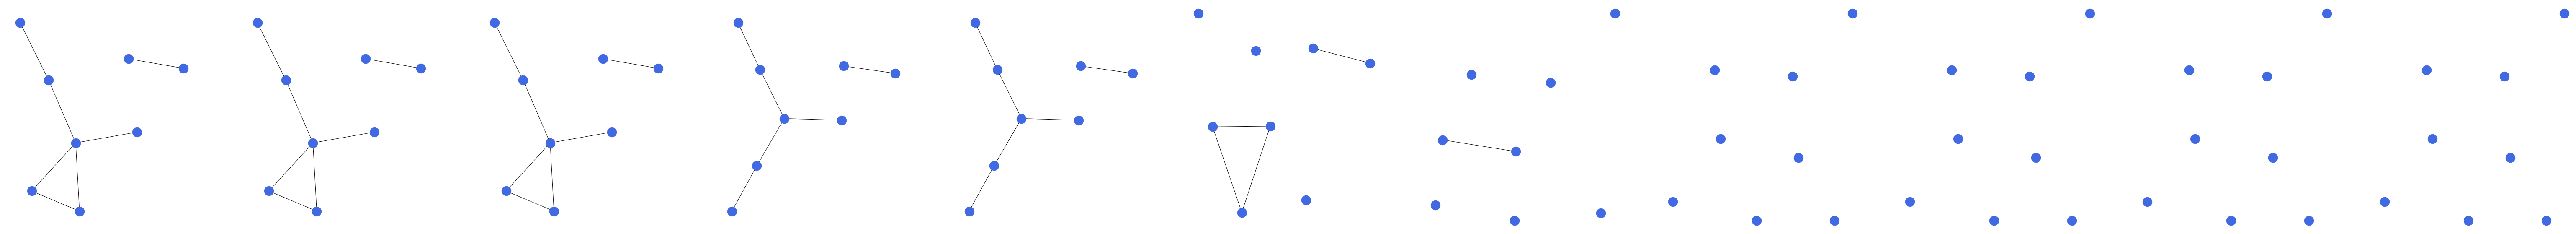

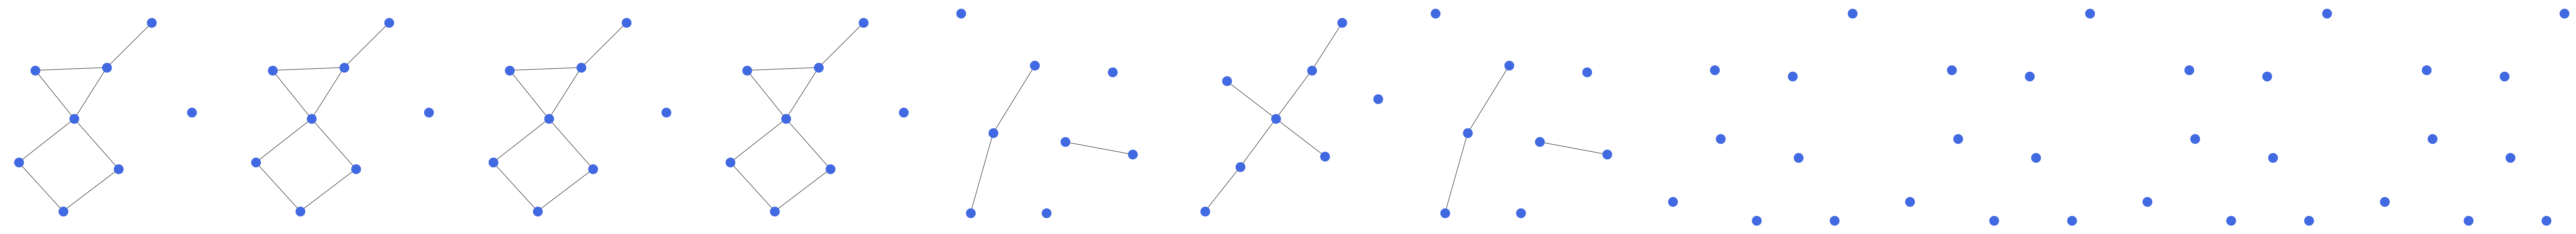

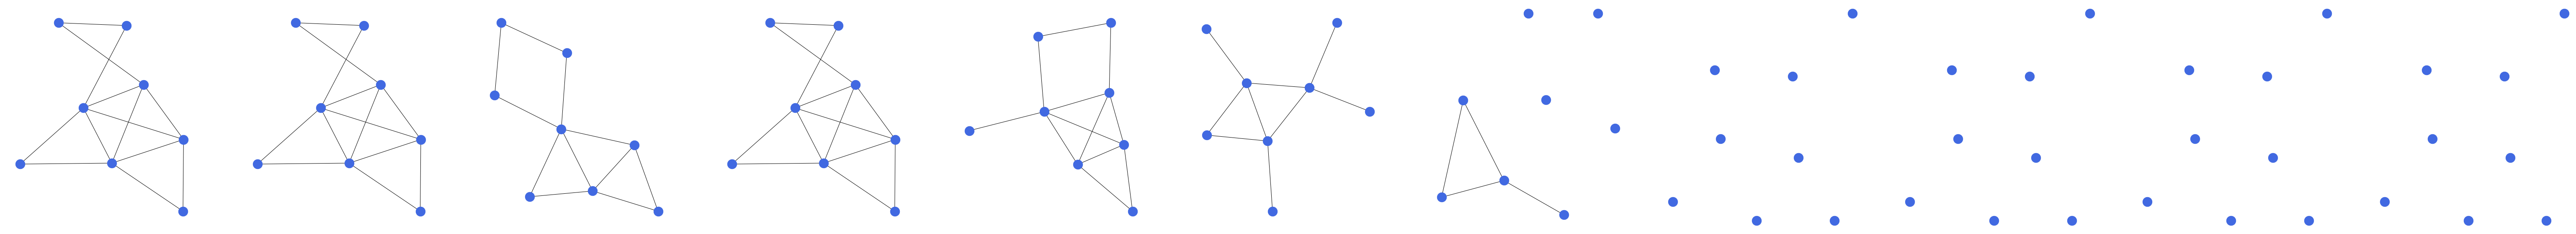

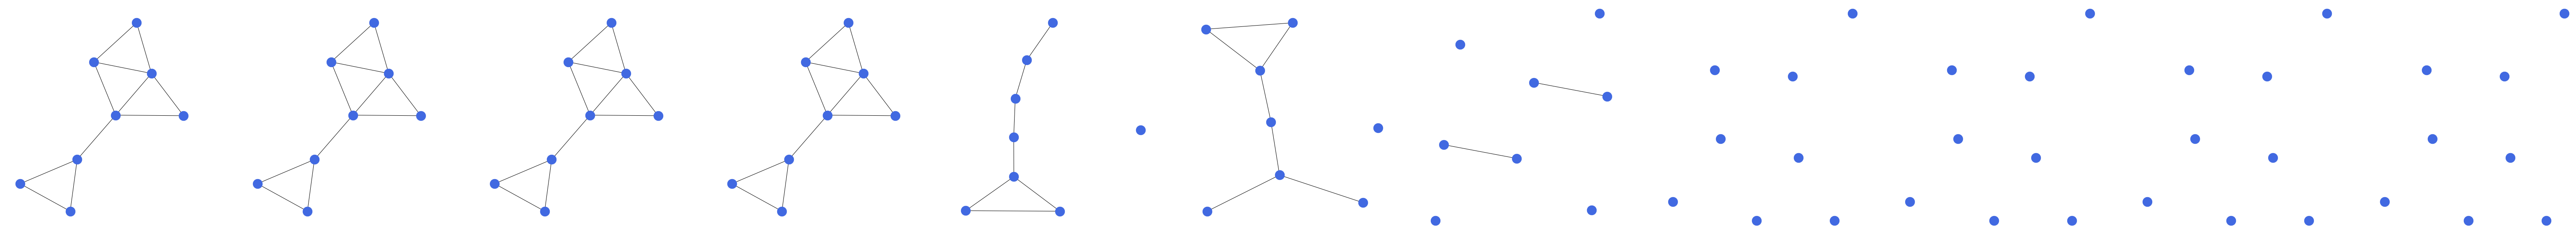

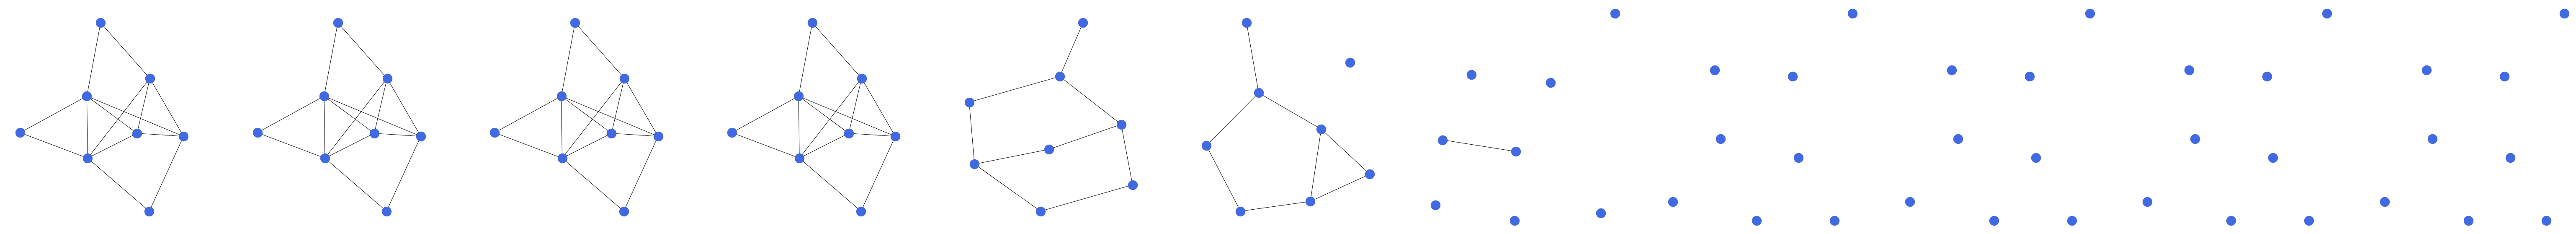

In [5]:
data = next(iter(data_loader))
e0, edge_batch_inds = graph_conversions.pyg_data_to_edge_vector(data, return_batch_inds=True)
graphs_0 = graph_conversions.split_pyg_data_to_nx_graphs(data)

t_limit = 1000
num_steps = 10

for diff_name, diff_class in [
    ("bit-flip", discrete_diffusers.BernoulliSkipDiffuser),
    ("bit-one", discrete_diffusers.BernoulliOneSkipDiffuser),
    ("bit-zero", discrete_diffusers.BernoulliZeroSkipDiffuser)
]:
    print(diff_name)
    diffused_graphs = []
    diffuser = diff_class(100, 10, (1,))  # Make input shape just 1
    for t in np.linspace(0, t_limit, num_steps + 1)[1:].astype(int):
        t_e = torch.tile(torch.tensor([t], device=DEVICE), (e0.shape[0],))
        et = diffuser.forward(e0[:, None], t_e, return_posterior=False)[:, 0]  # Do the noising on E x 1 tensors
        data.edge_index = graph_conversions.edge_vector_to_pyg_data(data, et)
        graphs_t = graph_conversions.split_pyg_data_to_nx_graphs(data)
        diffused_graphs.append(graphs_t)
    
    for i in range(len(graphs_0)):
        fig, ax = plt.subplots(ncols=(num_steps + 1), figsize=(10 * (num_steps + 1), 10))
        nx.draw(
            graphs_0[i], pos=nx.nx_pydot.graphviz_layout(graphs_0[i]),
            ax=ax[0], node_size=500, node_color="royalblue"
        )
        for j in range(num_steps):
            nx.draw(
                diffused_graphs[j][i], pos=nx.nx_pydot.graphviz_layout(diffused_graphs[j][i]),
                ax=ax[j + 1], node_size=500, node_color="royalblue"
            )
        fig.savefig(
            os.path.join(out_path, "%s_%d.svg" % (diff_name, i)),
            format="svg"
        )
        plt.show()